# Configuración del entorno de ejecución

## Importación de librerías

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from google.colab import files
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from collections import Counter

# P1: Carga de datos

In [102]:
url='https://raw.githubusercontent.com/DiegoPincheiraIb/EL4106_Assignments/main/Assignment2/HTRU_2.csv'
datos = pd.read_csv(url,names=['mean_prof','std_prof','exkurt_prof','skew_prof','mean_curve','std_curve','exkurt_curve','skew_curve','Class'])
print('Se tiene a continuación los datos importados:')
print(datos)

Se tiene a continuación los datos importados:
        mean_prof   std_prof  exkurt_prof  skew_prof  mean_curve  std_curve  exkurt_curve  skew_curve  Class
0      140.562500  55.683782    -0.234571  -0.699648    3.199833  19.110426      7.975532   74.242225      0
1      102.507812  58.882430     0.465318  -0.515088    1.677258  14.860146     10.576487  127.393580      0
2      103.015625  39.341649     0.323328   1.051164    3.121237  21.744669      7.735822   63.171909      0
3      136.750000  57.178449    -0.068415  -0.636238    3.642977  20.959280      6.896499   53.593661      0
4       88.726562  40.672225     0.600866   1.123492    1.178930  11.468720     14.269573  252.567306      0
...           ...        ...          ...        ...         ...        ...           ...         ...    ...
17893  136.429688  59.847421    -0.187846  -0.738123    1.296823  12.166062     15.450260  285.931022      0
17894  122.554688  49.485605     0.127978   0.323061   16.409699  44.626893      2

# P1: Base de datos

Debido a la desproporción del conjunto, se elabora una función que permite dividir la base de datos de manera distinta de acuerdo a un parámetro otorgado: **Train_Test_Split_V2()**; si el parámetro booleano otorgado es True, divide de forma de obtener 50/50 respecto a clases en el conjunto de entrenamiento; en caso contrario, mantiene la proporción del conjunto original.

In [103]:
def Train_Test_Split_V2(df_obj_input_og: pd.DataFrame, frac_train:float = 0.8, split_by_least_common = True) -> (pd.DataFrame, pd.DataFrame):
  """ 
  Dado un dataframe de entrada, un float entre 0 y 1, y un booleano, realiza las
  siguientes operaciones:
  1. Copia el dataframe de entrada.
  2. Extrae la fracción dada por el float de entrada a los elementos del
     conjunto dado sus clases, guardando estos en dos dataframes aparte.
     Dependiendo del booleano otorgado en la iniciación, se presentan dos casos:
      a) Con el booleano = True, se toma el largo del conjunto con la menor
         cantidad de elementos (en este caso, la clase positiva), y se toma una
         porción del conjunto de datos original de clase negativa de cantidad
         igual al largo calculado anteriormente, con el fin de que haya una
         proporción de 50/50 en el conjunto de entrenamiento. Esta porción
         sobreescribe el conjunto de datos calculado al principio del paso n°2.
      b) Con el booleano = False, no se realizan cambios al conjunto calculado
         al principio del paso n°2.
  3. Genera el conjunto de entrenamiento concatenando ambos dataframes
  obtenidos anteriormente.
  4. Se resta el conjunto de entrenamiento obtenido al dataframe de entrada,
  obteniendo así el conjunto de test.
  5. Se retornan el conjunto de entrenamiento y test.
  """
  df_obj_input = copy.deepcopy(df_obj_input_og)
  df_1_train = df_obj_input.loc[df_obj_input.iloc[:,-1] == 1].sample(frac = frac_train).reset_index(drop=True)
  df_0_train = df_obj_input.loc[df_obj_input.iloc[:,-1] == 0].sample(frac = frac_train).reset_index(drop=True)
  if split_by_least_common:
      len_df_1_train = len(df_1_train)
      df_0_train = df_obj_input.loc[df_obj_input.iloc[:,-1] == 0].sample(n = len_df_1_train).reset_index(drop=True)
  df_train_output = pd.concat([df_0_train, df_1_train]).sample(frac = 1).reset_index(drop=True)
  filtrado = pd.concat([df_train_output,df_obj_input]).reset_index(drop=True)
  df_test_output = copy.deepcopy(filtrado)
  df_test_output = df_test_output.drop_duplicates(keep = False).reset_index(drop=True)
  return df_train_output, df_test_output

Se crean los conjuntos para ambas versiones.

In [104]:
train_a, test_a = Train_Test_Split_V2(datos, split_by_least_common = True)
train_b, test_b = Train_Test_Split_V2(datos, split_by_least_common = False)

# P2: Modelo con histogramas

## P2.b) Cálculo de histogramas y bines

In [105]:
def Hist_Plotting(df_obj: pd.DataFrame, caract_obj: str, clase_obj: str, cant_bines = 15, plottear = True) -> (np.array, np.array):
  kwargs = dict(histtype='stepfilled',alpha=0.8, bins=cant_bines, stacked=True,density=True)
  kwargs_noplt = dict(bins=cant_bines,density=True)
  """
  Dado un dataframe objetivo, una característica objetivo, y una clase objetivo,
  genera un array de los valores de bines de los histogramas y un array de bines,
  graficando el histograma resultante. Retorna los arrays mencionados anteriormente.
  """
  if plottear == False:
    hist_obj, bins_obj = np.histogram(df_obj[caract_obj], **kwargs_noplt)
  else:
    hist_obj, bins_obj, _ = plt.hist(df_obj[caract_obj], label = 'datos ' + clase_obj, **kwargs)
    plt.legend(loc='best')
    plt.title('Histograma de ' + caract_obj + ' para datos ' + clase_obj)
    plt.show()
  return hist_obj, bins_obj

def Generador_Hist_Bines(df_obj, cant_bines = 15, plottear = True):
  """
  Dado un dataframe objetivo y una cantidad de bines, retorna un diccionario
  cuyas llaves principales son pulsar y no pulsar, y en los valores posee otro
  diccionario en donde se almacenan los histogramas y bines para cada uno de los
  datasets.
  """
  lista_caract = df_obj.columns.tolist()[:-1]
  dict_datos = {
      'pulsar': df_obj.loc[df_obj['Class'] == 1], 
      'no pulsar': df_obj.loc[df_obj['Class'] == 0]
      }
  dict_obj = {
      'pulsar': {
          'histogramas': [],
          'bines': []
      },
      'no pulsar': {
          'histogramas': [],
          'bines': []
      }
  }

  for key in dict_obj:
    for caract_obj in lista_caract:
      hist_obj, bins_obj = Hist_Plotting(dict_datos[key], caract_obj, key, cant_bines, plottear)
      dict_obj[key]['histogramas'].append(hist_obj)
      dict_obj[key]['bines'].append(bins_obj)
  return dict_obj

Se genera un diccionario que contiene los bines y sus valores.

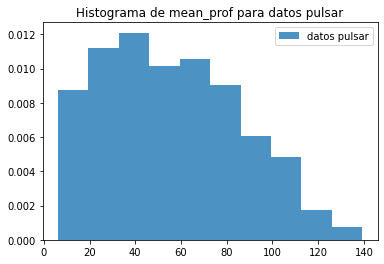

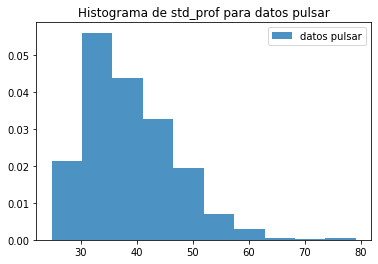

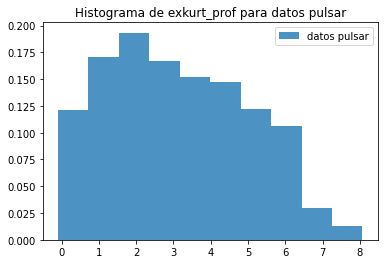

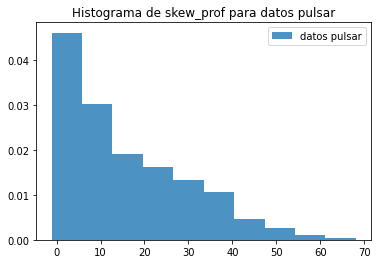

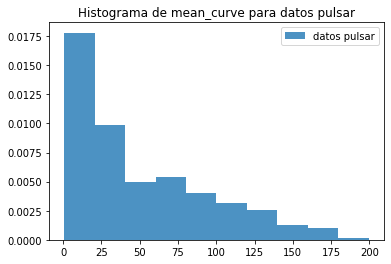

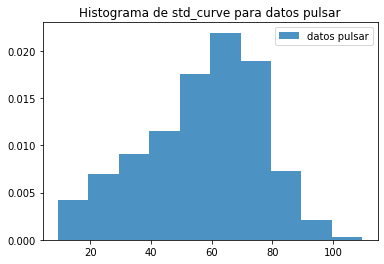

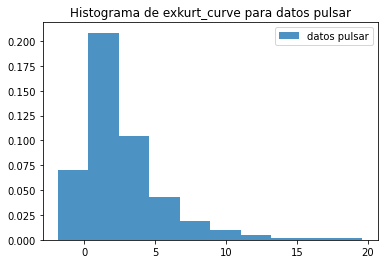

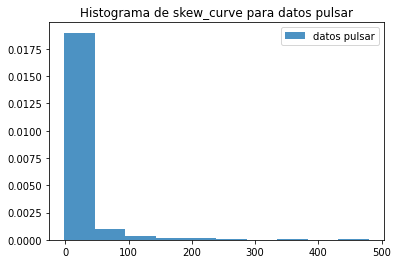

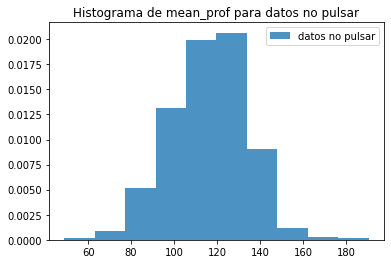

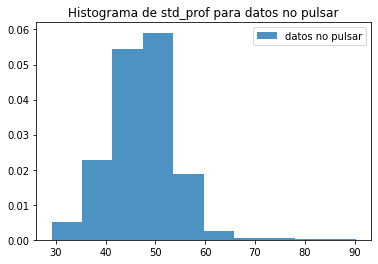

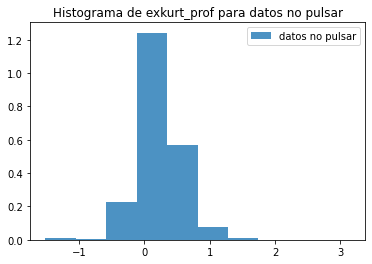

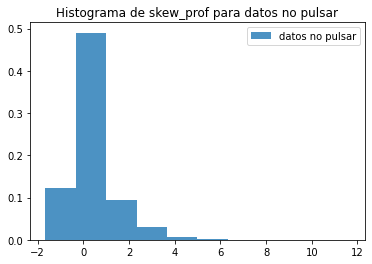

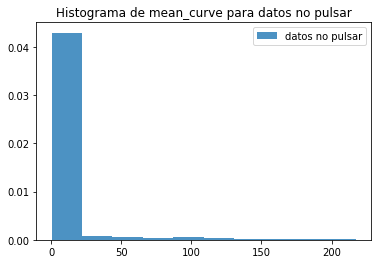

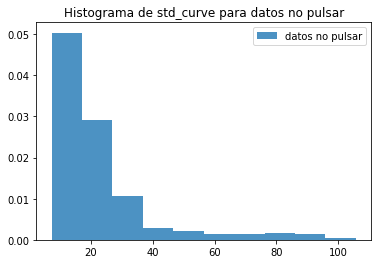

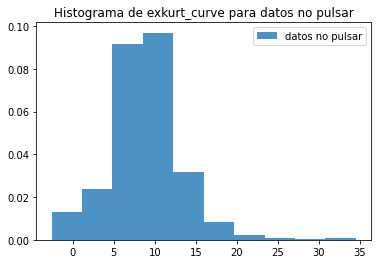

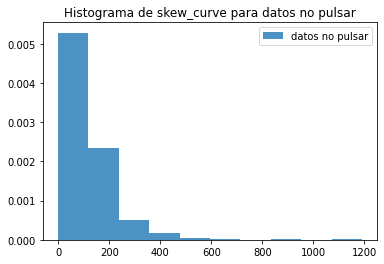

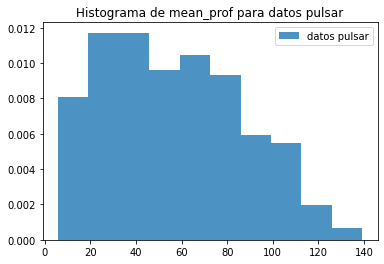

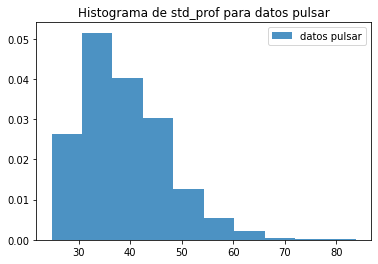

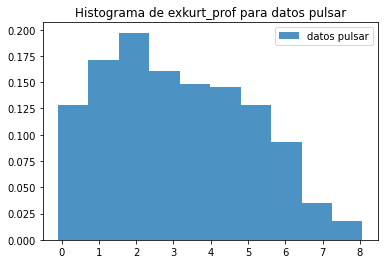

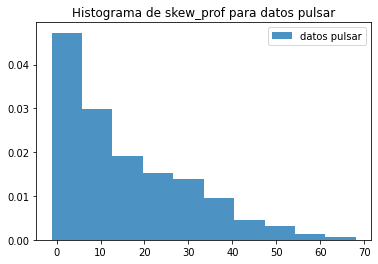

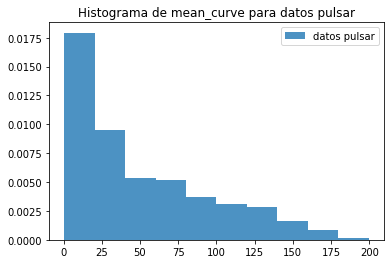

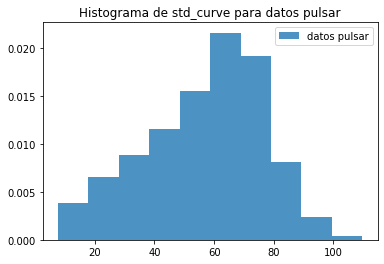

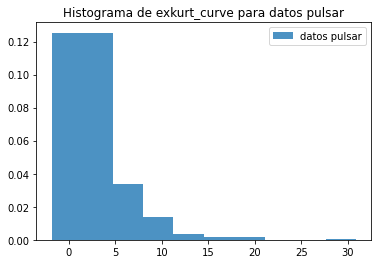

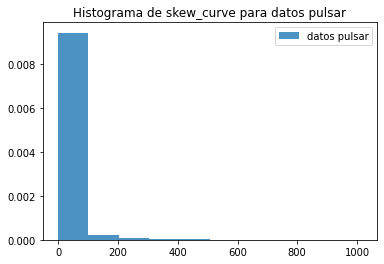

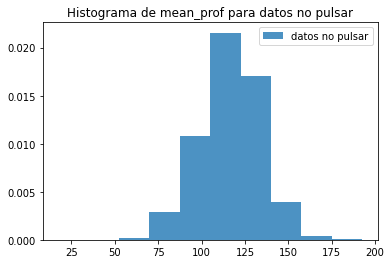

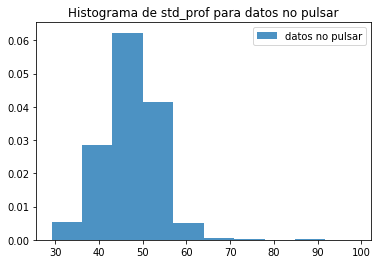

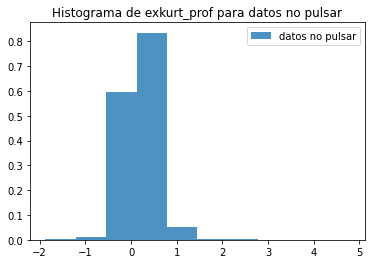

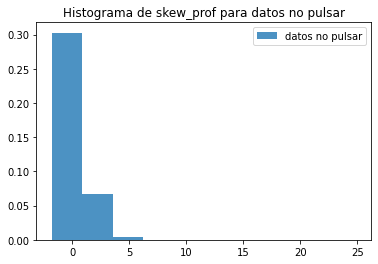

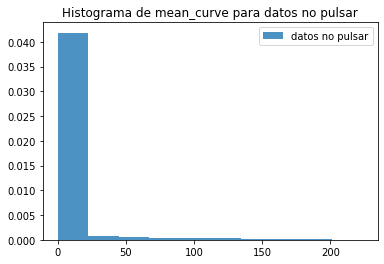

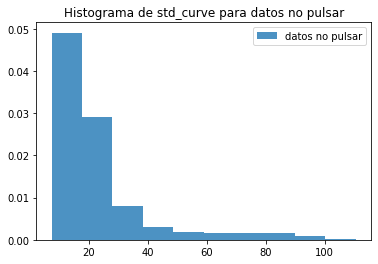

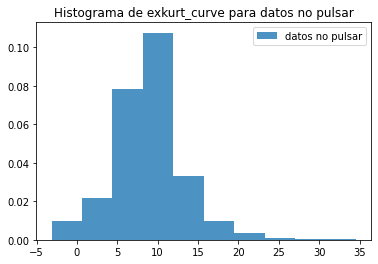

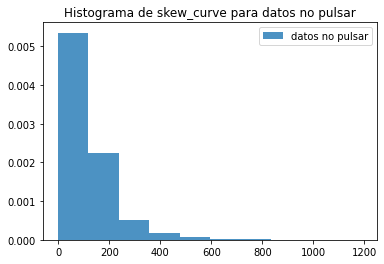

In [106]:
dict_hist_bines_a = Generador_Hist_Bines(train_a,10)
dict_hist_bines_b = Generador_Hist_Bines(train_b,10)

## P2.c) Cálculo de verosimilitudes

In [107]:
def Calculo_Verosimilitud(df_input, dict_hist_bines_obj):
  """ 
  Dado un dataframe de entrada, y un diccionario que contiene los histogramas y
  bines, se genera una lista con las verosimilitudes de cada uno de los elementos
  del dataframe objetivo. Para ello:
  1. Itero por cada fila del dataset, tomando las características de dicha instancia.
  2. 
  """
  output_list = []
  for k in range(len(df_input)): # Itero por cada fila del dataset
    data_obj = df_input.iloc[k,0:8] # fila de datos obj
    output_dict = {
        'pulsar': 0,
        'no pulsar': 0
    }
    for key in output_dict: # Por cada caso de elementos pulsar y no pulsar
      verosimilitudes = np.ones(len(data_obj)) # Genero un array donde guardo las verosimilitudes
      for i in range(0,len(data_obj)): # Por cada característica de la fila (menos la clase)
        for j in range(0, len(dict_hist_bines_obj[key]['bines'][i])-1): # Por cada uno de los bines
          if dict_hist_bines_obj[key]['bines'][i][j]< data_obj[i] < dict_hist_bines_obj[key]['bines'][i][j+1]: # Si el valor se encuentra entre dos bines:
            verosimilitudes[i] = dict_hist_bines_obj[key]['histogramas'][i][j] # Lo guardo en el arreglo de verosimilitudes
      output_dict[key] = np.prod(verosimilitudes)
    output_list.append(output_dict)
  return output_list

In [108]:
verosim_train_a = Calculo_Verosimilitud(train_a, dict_hist_bines_a)
verosim_test_a = Calculo_Verosimilitud(test_a, dict_hist_bines_a)

In [109]:
verosim_train_b = Calculo_Verosimilitud(train_b, dict_hist_bines_b)
verosim_test_b = Calculo_Verosimilitud(test_b, dict_hist_bines_b)

## Clasificación por verosimilitud

In [110]:
def Clasificacion(theta_array_obj,verosimil_cjto, cota_max = 9999999):
  """ 
  Dado un array de thetas y una lista que contiene diccionarios en los que se encuentra
  contenida la verosimilitud de un conjunto, se clasifican los elementos contenidos
  en dicha lista de acuerdo a su verosimilitud, retornado un array de dos dimensiones.
  Este array organiza en su primera dimensión los thetas utilizados en el array de entrada,
  mientras que en la segunda dimensión se encuentran obtenidas las predicciones para cada
  uno de los elementos del conjunto representado en la verosimilitud ingresada.
  
  Para ello:
  1. Se itera sobre cada theta
  2. Por cada uno de los elementos contenidos en el conjunto de verosimilitud, se
    dividen los valores de verosimilitud entre ambas clases (pulsar/no pulsar).
    Si el valor de esta visión es mayor a theta, se clasifica como 1 (pulsar); en
    caso contrario, se clasifica como 0 (no pulsar)-
    **  Si el valor de la verosimilitud no pulsar es igual a 0, se interpreta que
        el elemento solo puede corresponder a una clase pulsar, por lo que se fija
        un valor a la división mayor que cualquier theta contenido en el array de
        tal forma que se desige como pulsar.  
  """
  output_array = np.zeros((len(theta_array_obj), len(verosimil_cjto)))
  for idx_th, theta in enumerate(theta_array_obj):
    for idx_cjto, verosimil_obj in enumerate(verosimil_cjto):
      division = cota_max
      if verosimil_obj['no pulsar'] != 0:
        division = np.divide(verosimil_obj['pulsar'], verosimil_obj['no pulsar'])
      if division > theta: # X es positivo (pulsar)
        output_array[idx_th][idx_cjto] = 1
      else:
        output_array[idx_th][idx_cjto] = 0
  return output_array

## P2.d) Curva ROC por histograma

In [111]:
def Metricas(theta_array_obj, y_pred_obj, y_true_obj):
  """
  Dado un array de thetas, un array con los y predecidos, y otro array con los y
  verdaderos, se retorna un diccionario que contiene las siguientes métricas:
    * [VP]: Verdaderos Positivos
    * [VN]: Verdaderos Negativos
    * [FN]: Falsos Negativos
    * [FP]: Falsos Positivos
    * [TPR]: Tasa de Verdaderos Positivos
    * [FPR]: Tasa de Falsos Positivos
    * Precision
    * Recall
  """
  dict_metricas = {
    'VP' : np.zeros(len(theta_array_obj)),
    'FP' : np.zeros(len(theta_array_obj)),
    'VN' : np.zeros(len(theta_array_obj)),
    'FN' : np.zeros(len(theta_array_obj)),
    'TPR' : np.zeros(len(theta_array_obj)),
    'FPR' : np.zeros(len(theta_array_obj)),
    'Precision' : np.zeros(len(theta_array_obj)),
    'Recall' : np.zeros(len(theta_array_obj))
  }
  dict_aux = {
      '1': {
          '1': 'VP',
          '0': 'FP'
      },
      '0': {
          '1': 'FN',
          '0': 'VN'
      }
  }
  for idx_th, theta in enumerate(theta_array_obj):
    for y_pred, y_true in zip(y_pred_obj[idx_th], y_true_obj):
      str_aux = dict_aux[str(int(y_pred))][str(y_true)]
      dict_metricas[str_aux][idx_th] +=1
    dict_metricas['TPR'][idx_th] = dict_metricas['VP'][idx_th] / (dict_metricas['VP'][idx_th] + dict_metricas['FN'][idx_th])
    dict_metricas['FPR'][idx_th] = dict_metricas['FP'][idx_th] / (dict_metricas['FP'][idx_th] + dict_metricas['VN'][idx_th])
    dict_metricas['Precision'][idx_th] = dict_metricas['VP'][idx_th] / (dict_metricas['VP'][idx_th] + dict_metricas['FP'][idx_th])
    dict_metricas['Recall'][idx_th] = dict_metricas['VP'][idx_th] / (dict_metricas['VP'][idx_th] + dict_metricas['FN'][idx_th])
  return dict_metricas

In [112]:
def Curva_ROC(dict_metricas_obj, str_obj):
  ROC = np.array([[0.,0],[1,1]])
  for fpr, tpr in zip(dict_metricas_obj['FPR'], dict_metricas_obj['TPR']):
    ROC = np.concatenate((ROC, np.array([[fpr, tpr]])),axis=0)

  ROC = tuple(map(tuple, ROC))

  def getKey(item):
    return item[0]
  ROC = sorted(ROC, key=getKey)

  X_FPR = [x[0] for x in ROC]
  Y_TPR = [x[1] for x in ROC]

  plt.plot(X_FPR,Y_TPR)
  plt.plot(X_FPR,Y_TPR,'or')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('Curva ROC a base de ' + str_obj)
  plt.show()

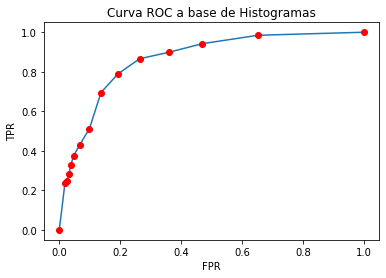

In [113]:
theta_array = np.logspace(-6,6,13)
y_pred_a_hist = Clasificacion(theta_array, verosim_test_a)
dict_metricas_a_hist = Metricas(theta_array, y_pred_a_hist, test_a.iloc[:,-1])
Curva_ROC(dict_metricas_a_hist, 'Histogramas')

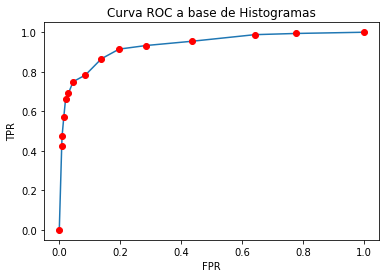

In [114]:
y_pred_b_hist = Clasificacion(theta_array, verosim_test_b)
dict_metricas_b_hist = Metricas(theta_array, y_pred_b_hist, test_b.iloc[:,-1])
Curva_ROC(dict_metricas_b_hist, 'Histogramas')

## P2.e) Curva Precision/Recall

In [115]:
def Curva_PR(dict_metricas_obj, str_obj):
  PR = np.array([[0.,1]])
  for rec, pre in zip(dict_metricas_obj['Recall'], dict_metricas_obj['Precision']):
    PR = np.concatenate((PR, np.array([[rec, pre]])),axis=0)

  PR = tuple(map(tuple, PR))

  def getKey(item):
    return item[0]
  PR = sorted(PR, key=getKey)

  X_REC = [x[0] for x in PR]
  Y_PRE = [x[1] for x in PR]

  plt.plot(X_REC,Y_PRE)
  plt.plot(X_REC,Y_PRE,'or')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Curva Precision/Recall a base de ' + str_obj)
  plt.show()

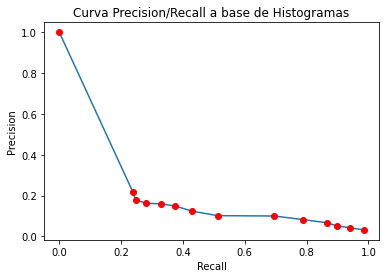

In [116]:
y_pred_a_hist = Clasificacion(theta_array, verosim_test_a)
dict_metricas_a_hist = Metricas(theta_array, y_pred_a_hist, test_a.iloc[:,-1])
Curva_PR(dict_metricas_a_hist, 'Histogramas')

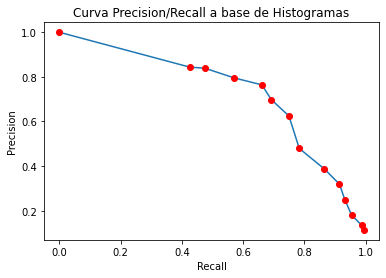

In [117]:
y_pred_b_hist = Clasificacion(theta_array, verosim_test_b)
dict_metricas_b_hist = Metricas(theta_array, y_pred_b_hist, test_b.iloc[:,-1])
Curva_PR(dict_metricas_b_hist, 'Histogramas')

Debido al pobre desempeño del conjunto "a", se descarta este para los siguientes cálculos.

# P3: Modelo gaussiano

## P3.b) Media y Matriz de Covarianza del modelo gaussiano

In [118]:
def InverseCovMtx(cjto_obj):
  """
  Dado un datraframe objetivo, se calcula la inversa de la matriz de covarianza
  de dichos datos (sin contar la clase). 
  """
  df_cov = cjto_obj.iloc[:,0:8].copy().cov().copy()
  mtx_cov = df_cov.values
  mtx_obj = np.linalg.inv(mtx_cov) # Inverso Matriz Covarianza
  return mtx_cov, mtx_obj

def Mean_InvCovMtx_Generator(df_obj):
  """ Dado un dataframe objetivo, se genera un diccionario cuyas llaves corresponden
  a los datos pulsar y no pulsar, y en los valores de dichas llaves se encuentra otro
  diccionario que contiene la media y la inversa de la matriz de correlación del
  dataframe objetivo (sin contar la clase).
  """
  dict_datos = {
      'pulsar': df_obj.loc[df_obj['Class'] == 1], 
      'no pulsar': df_obj.loc[df_obj['Class'] == 0]
      }
  dict_output = {
      'pulsar': {
          'Mean': np.zeros(8),
          'Cov': None,
          'Inv Cov': None,
      },
      'no pulsar': {
          'Mean': np.zeros(8),
          'Cov': None,
          'Inv Cov': None,
      }
  }
  for key_pulsar in dict_output:
    for i in range(8):
      dict_output[key_pulsar]['Mean'][i] = np.mean(dict_datos[key_pulsar].iloc[:,i])
      dict_output[key_pulsar]['Cov'], dict_output[key_pulsar]['Inv Cov'] = InverseCovMtx(dict_datos[key_pulsar].iloc[:,0:8])
  return dict_output

In [119]:
dict_gauss_train_b = Mean_InvCovMtx_Generator(train_b)

## P3.c) Cálculo de verosimilitudes

In [120]:
def FDP_Gaussian(df_obj, dict_gauss_obj):
  """ Dado un dataframe objetivo, y un diccionario que contiene un vector de media,
  una matriz de covarianza y su inversa para los datos pulsar y no pulsar, retorna
  una lista que contiene un diccionario por cada elemento del dataframe objetivo.
  Estos diccionarios poseen como llaves "pulsar" o "no pulsar", y en los valores
  se almacenan las verosimilitudes correspondientes a dichas llaves utilizando
  una FDP Gaussiana.
  """
  output_list = []
  power_pi = np.power((2*np.pi),((len(df_obj.iloc[0,0:8])-1)/2))

  for k in range(len(df_obj)): # Itero por cada fila del dataset
    data_obj = df_obj.iloc[k,0:8] # fila de datos obj
    output_dict = {
        'pulsar': 0,
        'no pulsar': 0
    }
    for key in output_dict: # Por cada caso de elementos pulsar y no pulsar
      power_cov = np.power((np.linalg.det(dict_gauss_obj[key]['Cov'])), (1/2))
      den_FDP = power_pi * power_cov
      x_minus_mu = data_obj.to_numpy() - dict_gauss_obj[key]['Mean']
      first_mult = np.dot(x_minus_mu.T, dict_gauss_obj[key]['Inv Cov'])
      sec_mult = np.dot(first_mult, x_minus_mu)
      num_FDP = np.exp((-1/2)*sec_mult)
      output_dict[key] = np.divide(num_FDP,den_FDP)
    output_list.append(output_dict)
  return output_list

In [121]:
verosim_gauss = FDP_Gaussian(test_b, dict_gauss_train_b)

## P3.d) Curva ROC de modelo gaussiano

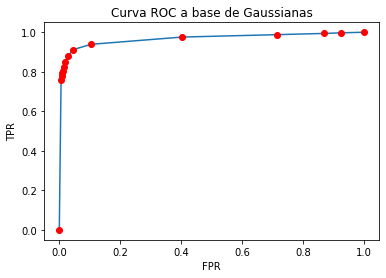

In [122]:
y_pred_b_gauss = Clasificacion(theta_array, verosim_gauss)
dict_metricas_b_gauss = Metricas(theta_array, y_pred_b_gauss, test_b.iloc[:,-1])
Curva_ROC(dict_metricas_b_gauss, 'Gaussianas')

## P3.e) Curva Precision/Recall

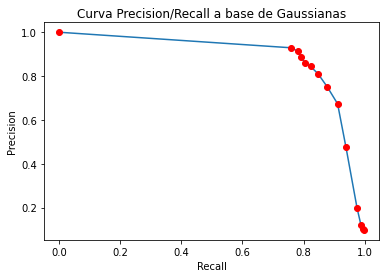

In [123]:
Curva_PR(dict_metricas_b_gauss, 'Gaussianas')

# P4: Comparación entre modelos

## P4.a) Comparación entre curvas ROC

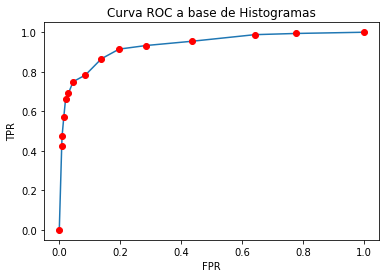

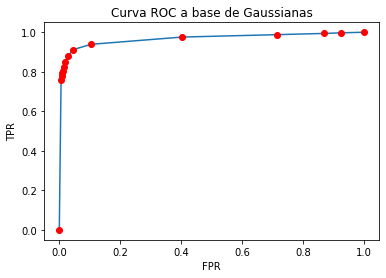

In [129]:
Curva_ROC(dict_metricas_b_hist, 'Histogramas')
Curva_ROC(dict_metricas_b_gauss, 'Gaussianas')

## P4.b) Comparación entre curvas Precision/Recall

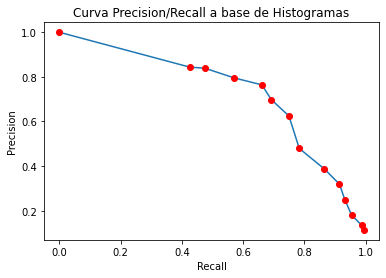

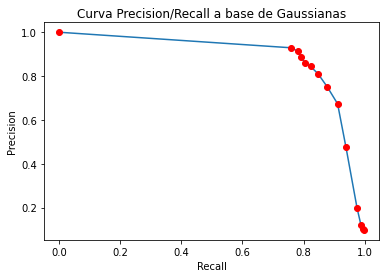

In [127]:
Curva_PR(dict_metricas_b_hist, 'Histogramas')
Curva_PR(dict_metricas_b_gauss, 'Gaussianas')

## P4.c) Función **tarea1**

In [124]:
def Histogramas_Full(train_obj, test_obj, theta_array = np.logspace(-6, 6, 13)):
  dict_hist_bines_obj = Generador_Hist_Bines(train_obj, 10, plottear = False)
  verosim_test_obj = Calculo_Verosimilitud(test_obj, dict_hist_bines_obj)
  y_pred_obj =  Clasificacion(theta_array, verosim_test_obj)
  dict_metricas_obj = Metricas(theta_array, y_pred_obj, test_obj.iloc[:,-1])
  Curva_ROC(dict_metricas_obj, 'Histogramas')
  Curva_PR(dict_metricas_obj, 'Histogramas')
  return dict_metricas_obj

def Gaussian_Full(train_obj, test_obj, theta_array = np.logspace(-6, 6, 13)):
  dict_gauss_train = Mean_InvCovMtx_Generator(train_obj)
  verosim_gauss_obj = FDP_Gaussian(test_obj, dict_gauss_train)
  y_pred_obj = Clasificacion(theta_array, verosim_gauss_obj)
  dict_metricas_obj = Metricas(theta_array, y_pred_obj, test_obj.iloc[:,-1])
  Curva_ROC(dict_metricas_obj, 'Gaussianas')
  Curva_PR(dict_metricas_obj, 'Gaussianas')
  return dict_metricas_obj

def tarea1(train_obj, test_obj):
  metricas_hist_output = Histogramas_Full(train_obj, test_obj)
  metricas_gauss_output = Gaussian_Full(train_obj, test_obj)
  return metricas_hist_output, metricas_gauss_output

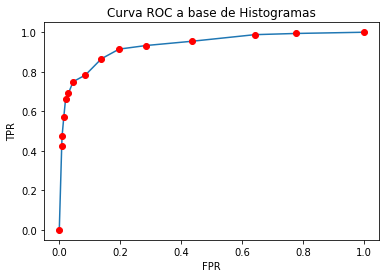

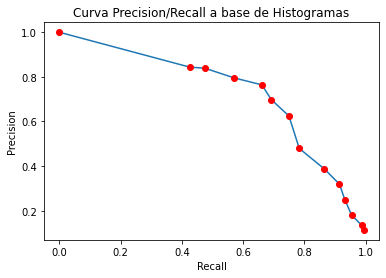

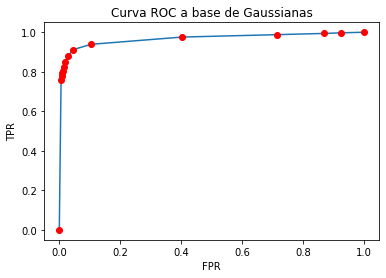

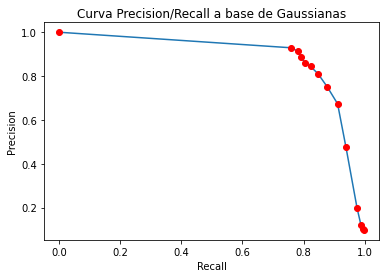

In [125]:
metricas_hist, metricas_gauss = tarea1(train_b, test_b)